# Deep learning for tumor vs non tumor image classification

In [2]:
#General libraries
import os,re,random,time,csv
import numpy as np
import pandas as pd

#Image processing
from skimage import measure,morphology
from skimage.measure import regionprops,label
import SimpleITK as sitk
import cv2

#Plot graphs
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
sns.set(context='talk', style='whitegrid')

#Keras & TF
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D 
from keras.layers import UpSampling2D, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam , SGD
from keras.models import Model
from keras.preprocessing import image
from livelossplot import PlotLossesKeras
from sklearn import model_selection
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator

K.set_image_data_format('channels_last')
%matplotlib inline

Using TensorFlow backend.


# Generate training data

<b>If you dont bring your data and you want to use already prepared dataset you can skip this part</b>

In [3]:
%%time
#Searching for patients files, creating patient dictionary

def parse_dir(general_path):
    patients = next(os.walk(general_path))[1]
    print(len(patients),r' Patients found')
    Patient_dict={}
    temp_img=''
    temp_mask=''
    i=0


    for patient in patients:
        for root, dirs, files in os.walk(general_path+'/'+patient):
            for file in files:
                if re.search('mask',file.lower()):
                    temp_mask = file
                    for imgfile in files:
                        if re.search('image',imgfile.lower()):
                            temp_img = imgfile
                            Patient_dict[patient[0:9]]=[os.path.join(general_path,patient,temp_img),os.path.join(general_path,patient,temp_mask)]
                            i+=1
                            temp_mask=''
                            temp_img=''
    return Patient_dict



general_path = r'.\patients' 
general_path = r'E:\SergeyData\For workshop\MAASTRO-CT-Lung1(nrrds)'
Patient_dict = parse_dir(general_path)

424  Patients found
Wall time: 56.4 ms


Next step is to prepare the images for classification problem, to simplify the task lets convert them to jpg format. Because jpg images usually has 3 channels (RGB) we can fill these chanels with different dicom slices. Lets use 3 Central ones.


In [46]:
def convert_images(Patient_dict,path,tum = True,plot_imgs = True):
    from tqdm import tqdm

    for patient in tqdm(Patient_dict.keys()):
        patient_image = sitk.GetArrayFromImage(sitk.ReadImage(Patient_dict[patient][0]))
        patient_mask = sitk.GetArrayFromImage(sitk.ReadImage(Patient_dict[patient][1]))
        mask_region = regionprops(1*(patient_mask>0))
        
        if tum:
            ind = mask_region[0].bbox[3]-int((mask_region[0].bbox[3]-mask_region[0].bbox[0])/2)
            ind_list = [ind-1,ind,ind+1]
        elif mask_region[0].bbox[3]-int((mask_region[0].bbox[3]-mask_region[0].bbox[0])/2) > int(patient_mask.shape[0]/2):
            ind = mask_region[0].bbox[0]
            ind_list = [ind-2,ind-3,ind-4]
        else:
            ind = mask_region[0].bbox[3]
            ind_list = [ind+2,ind+3,ind+4]

              
        if plot_imgs:
            fig,ax = plt.subplots(2,3,figsize=(20,10))
            ax[0,0].imshow(patient_image[ind_list[0],...],cmap='bone')
            ax[0,0].axis('off')
            ax[0,0].set_title('Central-1 GTV img slice',fontsize=20)
            ax[0,1].imshow(patient_image[ind_list[1],...],cmap='bone')
            ax[0,1].axis('off')
            ax[0,1].set_title('Central GTV img slice',fontsize=20)
            ax[0,2].imshow(patient_image[ind_list[2],...],cmap='bone')
            ax[0,2].set_title('Central+1 GTV img slice',fontsize=20)
            ax[0,2].axis('off')
            ax[1,0].imshow(patient_mask[ind_list[0],...],cmap='bone')
            ax[1,0].axis('off')
            ax[1,0].set_title('Central-1 GTV mask slice',fontsize=20)
            ax[1,1].imshow(patient_mask[ind_list[1],...],cmap='bone')
            ax[1,1].axis('off')
            ax[1,1].set_title('Central GTV mask slice',fontsize=20)
            ax[1,2].imshow(patient_mask[ind_list[2],...],cmap='bone')
            ax[1,2].set_title('Central +1 GTV mask slice',fontsize=20)
            ax[1,2].axis('off')
            plot_imgs = False


        try:
            jpg_image = np.array([patient_image[idx,...] for idx in ind_list])
            jpg_image[jpg_image<-999]=-1000                           #Lung window
            jpg_image[jpg_image>149]=150
            jpg_image+=1000
            jpg_image = np.array((jpg_image/(1.0*np.max(jpg_image.flatten())))*255,np.uint8)
            jpg_image = np.swapaxes(jpg_image,0,2)
            jpg_image = np.swapaxes(jpg_image,1,0)
            imageio.imwrite(os.path.join(path,'%s.jpg'%patient), jpg_image)
        except:
            pass
    return None
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 419/419 [07:43<00:00,  1.16s/it]


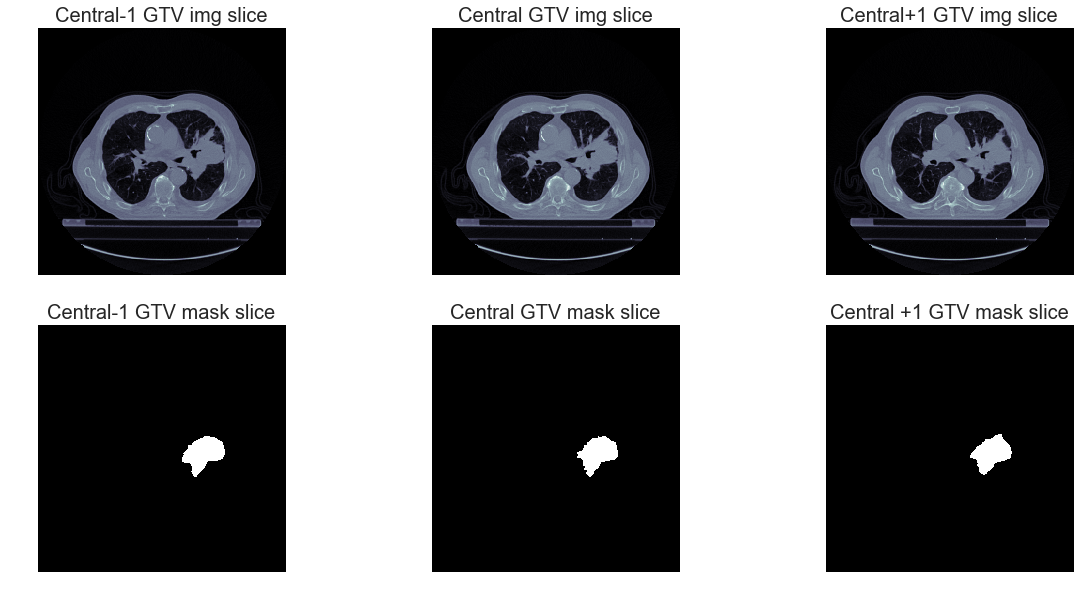

In [47]:
#Generate jpeg images containing tumor from nrrd images
convert_images(Patient_dict,r'E:\SergeyData\For workshop\deleteme\tum',tum = True,plot_imgs = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 419/419 [07:37<00:00,  1.13s/it]


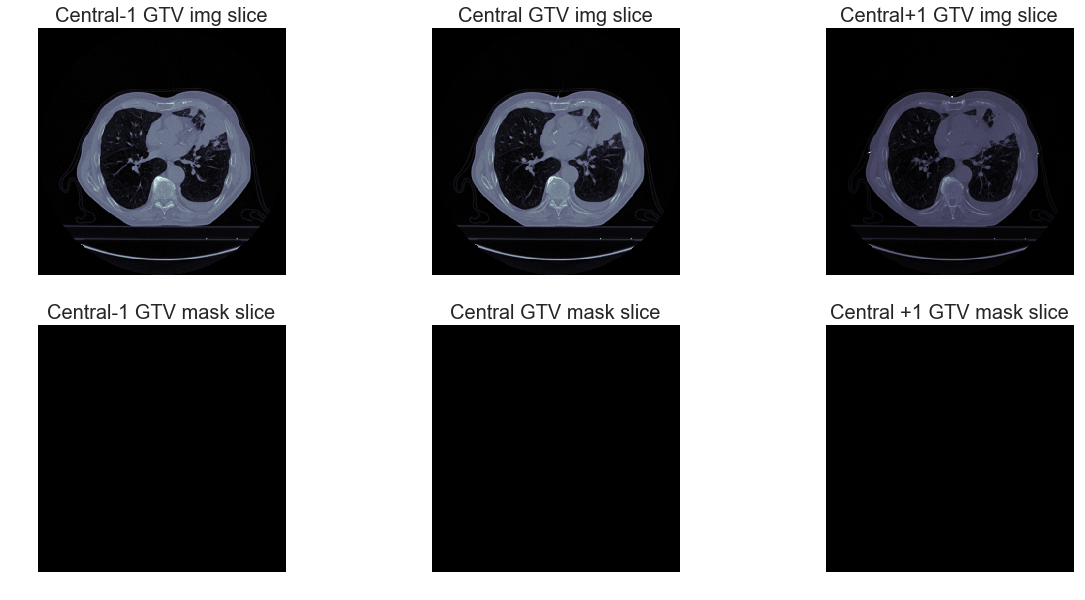

In [48]:
#Generate jpeg images without tumor from nrrd images
convert_images(Patient_dict,r'E:\SergeyData\For workshop\deleteme\neg',tum = False,plot_imgs = True)

# Load data and create training arrays

Now lets create training and test arrays from jpg images and labels

In [3]:
jpeg_dir = r'./For workshop/tum'  #set the path to folder with tumor images
patients = next(os.walk(jpeg_dir))[2]
jpeg_dir_no_tum = r'./For workshop/neg'   #set the path to folder with tumor negative images
patients_no_tum = next(os.walk(jpeg_dir_no_tum))[2]
print(len(patients),'Patients with tumor found and',len(patients_no_tum),'Patients without tumor found')

419 Patients with tumor found and 419 Patients without tumor found


In [4]:
from random import shuffle
random.seed(3)
images =[]
img_labels =[]

tumor_labels = list(np.hstack((np.ones(419),np.zeros(407))))
patients_combined = patients+patients_no_tum
print(len(tumor_labels),len(patients_combined))

flow = list(zip(patients_combined,tumor_labels))
random.shuffle(flow)
for patient_data in flow:
    if patient_data[1]==1:
        images.append(imageio.imread(os.path.join(jpeg_dir,patient_data[0])))
        img_labels.append(patient_data[1])
    else:
        images.append(imageio.imread(os.path.join(jpeg_dir_no_tum,patient_data[0])))
        img_labels.append(patient_data[1])
    
        
    

images_array = np.array(images)
labels_array = np.array(img_labels,np.uint8).reshape(-1,1)
print('Images array shape: ',images_array.shape,'Labels array shape: ',labels_array.shape)

826 838
Images array shape:  (826, 512, 512, 3) Labels array shape:  (826, 1)


In [5]:
#Normalize data before training
mean = np.mean(list(map(lambda x: np.mean(x),images_array)))
std = np.mean(list(map(lambda x: np.std(x),images_array)))
print(mean,std)
normalized_images = np.array(list(map(lambda x: (x-mean)/std,images_array)))
print(normalized_images.shape)

53.327593407003604 86.24599310139831
(826, 512, 512, 3)


Text(0,0.5,'# patients')

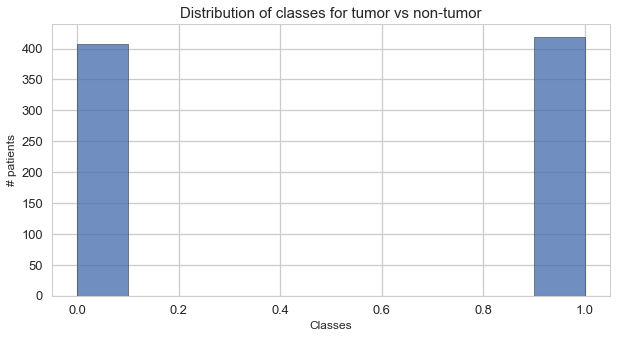

In [6]:
#Check the classes disribution 
plt.figure(figsize=(10,5))
fff = plt.hist(labels_array,bins=10,edgecolor='black', linewidth=0.5,alpha=0.8)
plt.title('Distribution of classes for tumor vs non-tumor',fontsize=15)
plt.xlabel('Classes',fontsize=12)
plt.ylabel('# patients',fontsize=12)

In [7]:
#Split data
x_train,x_test,y_train,y_test = model_selection.train_test_split(normalized_images,labels_array,test_size=0.3,random_state=1,stratify =labels_array)
print('X_train shape:',x_train.shape,'Y_train shape',y_train.shape)
print('X_test shape:',x_test.shape,'Y_test shape',y_test.shape)


X_train shape: (578, 512, 512, 3) Y_train shape (578, 1)
X_test shape: (248, 512, 512, 3) Y_test shape (248, 1)


In [54]:
#Lets initialize the model

In [8]:
def Create_a_model(input_shape):
    #base_model = keras.applications.mobilenet.MobileNet(input_shape=input_shape,include_top=False, weights='imagenet', pooling='max')
    base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False,input_shape=input_shape,pooling = 'avg')
    #base_model =keras.applications.inception_v3.InceptionV3(include_top=False,weights='imagenet',input_shape=input_shape)
    x = base_model.output
    print(x.shape)
    x = Dense(1024)(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    print(x.shape)
    predictions = Dense(1, activation='sigmoid')(x)
    print(predictions.shape)
    #for layer in base_model.layers[:-10]:
     #   layer.trainable = False
    model = Model(inputs=base_model.input, outputs=predictions) 
    return model

xcept_model = Create_a_model(x_train.shape[1:4])


(?, 2048)
(?, 1024)
(?, 1)


In [9]:
xcept_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [53]:
def cosine_annealing(x,c_lr):
    lr = 3e-6
    epochs = 70
    print('Learning rate is: %s'%str(lr*(np.cos(np.pi*x/epochs)+1.)/2))
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
    
learning_rate = keras.callbacks.LearningRateScheduler(cosine_annealing)

In [11]:
xcept_model.compile(optimizer=keras.optimizers.Adam(lr = 1e-6),loss='binary_crossentropy',metrics=['accuracy'])

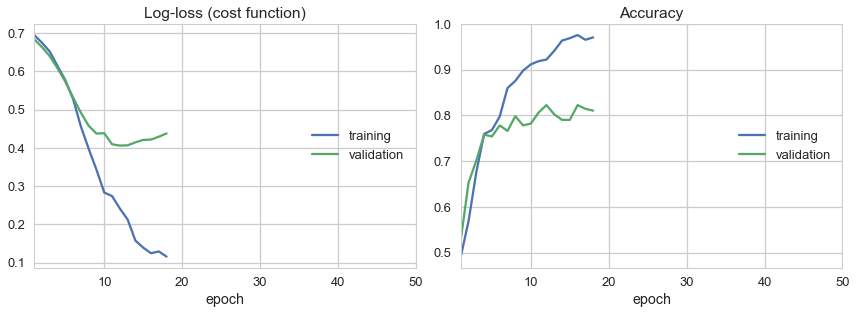

Epoch 19/50
Learning rate is: 2.5365939734802974e-06
160/578 [=======>......................] - ETA: 34s - loss: 0.0606 - acc: 1.0000

KeyboardInterrupt: 

In [12]:
history_back = xcept_model.fit(x_train, y_train, batch_size=8, epochs=50,
                                      validation_data=(x_test, y_test),callbacks=[learning_rate,PlotLossesKeras()])

In [13]:
#Calculate metrics
test_scores = xcept_model.evaluate(x_test,y_test)

print ("Loss = " + str(test_scores[0]))
print ("Test Accuracy = " + str(test_scores[1]))

248/248 [==============================] - 8s 31ms/step
Loss = 0.44710326723514066
Test Accuracy = 0.7822580664388595


In [14]:
#Function to plot the ROC curve
def plot_results(y_test,pred,descr)  :
    plt.figure(figsize=(8,8))
    plt.title(descr,fontsize=18)
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    roc_auc=(metrics.roc_auc_score(y_test,pred))
    print('-----------------------------')
    print('CNN Roc_auc score : ',roc_auc,)
    print('-----------------------------')
    fpr, tpr, thr = metrics.roc_curve(y_test, pred)
    plt.plot(fpr, tpr, label='Class %s'%1)
    plt.axis([-0.1, 1.1, -0.1, 1.1])
    plt.xlabel("FP rate",fontsize=18)
    plt.ylabel("TP rate",fontsize=18)
    plt.text(0.7,0.4,'ROC AUC = %s'%str(np.round(roc_auc,2)),fontsize=18)

-----------------------------
CNN Roc_auc score :  0.8810824876398646
-----------------------------


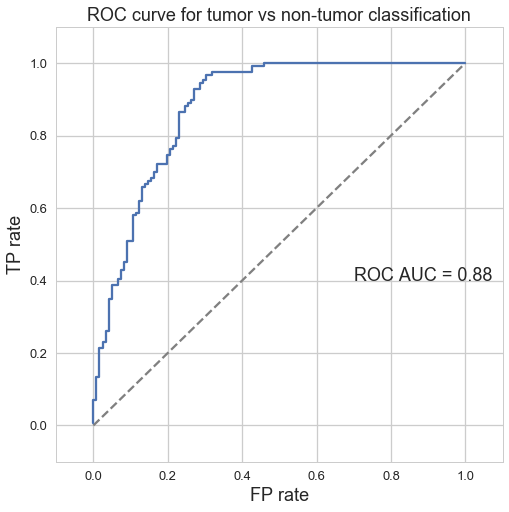

In [15]:
#Plotting ROC curve
predictions = xcept_model.predict(x_test)
plot_results(y_test,predictions,'ROC curve for tumor vs non-tumor classification')

#### Extra: apply image augmentation

In [33]:
#Image augmentation 
datagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.12,
    height_shift_range=0.12,
    zoom_range= 0.3,
    horizontal_flip=True)

In [ ]:
history_back = xcept_model.fit_generator(datagen.flow(x_train, y_train, batch_size=50), steps_per_epoch=20, epochs=100,
                                      validation_data=(x_test, y_test),callbacks=[learning_rate,PlotLossesKeras()])

In [30]:
#In case you are struggeling with starting the training process
#xcept_model_surv.load_weights('help.h5')

# Classify 2 yr survival

In [60]:
#lets open the clinical records file
clinical_rec = pd.read_csv('Workshop_clinical_data.csv')
display(clinical_rec.head(5))


,Unnamed: 0,Subject,survival_time_in_days,M/F
0,0,LUNG1-001,2165,M
1,1,LUNG1-002,155,M
2,2,LUNG1-003,256,M
3,3,LUNG1-004,141,M
4,4,LUNG1-005,353,M


In [61]:
#Lets create a dictionary with labels for 2 years survival
time_span = 730 #days
labels={}
for pat_n in range(len(clinical_rec['survival_time_in_days'])):
    labels[clinical_rec['Subject'][pat_n]] = clinical_rec['survival_time_in_days'][pat_n] >time_span
    
#Lets print first 10
for i in list(labels.keys())[0:10]:
    print(i,':',labels[i])

LUNG1-001 : True
LUNG1-002 : False
LUNG1-003 : False
LUNG1-004 : False
LUNG1-005 : False
LUNG1-006 : False
LUNG1-007 : False
LUNG1-008 : False
LUNG1-009 : False
LUNG1-010 : True


In [19]:
#For this task we will use only images with tumor
patients = next(os.walk(jpeg_dir))[2]

In [62]:
images =[]
img_labels =[]
for patient in patients:
    try:
        images.append(imageio.imread(os.path.join(jpeg_dir,patient)))
        img_labels.append(labels[patient[:-4]])
    except:
        print('Something wrong with patient: ',patient[:-4])

images_array = np.array(images)
labels_array = np.array(img_labels,np.uint8).reshape(-1,1)
print('Images array shape: ',images_array.shape,'Labels array shape: ',labels_array.shape)

Images array shape:  (419, 512, 512, 3) Labels array shape:  (419, 1)


In [21]:
#Normalize data before training
mean = np.mean(list(map(lambda x: np.mean(x),images_array)))
std = np.mean(list(map(lambda x: np.std(x),images_array)))
print(mean,std)
normalized_images = np.array(list(map(lambda x: (x-mean)/std,images_array)))
print(normalized_images.shape)

53.97225491774869 86.9674841524258
(419, 512, 512, 3)


Text(0,0.5,'# patients')

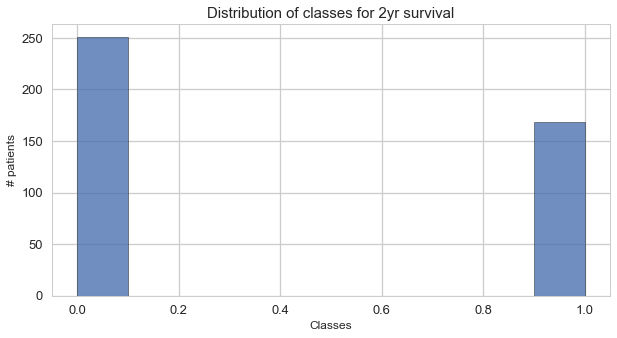

In [23]:
#Check the classes disribution 
plt.figure(figsize=(10,5))
fff = plt.hist(labels_array,bins=10,edgecolor='black', linewidth=0.5,alpha=0.8)
plt.title('Distribution of classes for 2yr survival',fontsize=15)
plt.xlabel('Classes',fontsize=12)
plt.ylabel('# patients',fontsize=12)

In [24]:
#Split data
x_train,x_test,y_train,y_test = model_selection.train_test_split(normalized_images,labels_array,test_size=0.3,random_state=1,stratify =labels_array)
print('X_train shape:',x_train.shape,'Y_train shape',y_train.shape)
print('X_test shape:',x_test.shape,'Y_test shape',y_test.shape)

X_train shape: (293, 512, 512, 3) Y_train shape (293, 1)
X_test shape: (126, 512, 512, 3) Y_test shape (126, 1)


In [25]:
xcept_model_surv = Create_a_model(x_train.shape[1:4])

(?, 2048)
(?, 1024)
(?, 1)


In [27]:
xcept_model_surv.compile(optimizer=keras.optimizers.Adam(lr = 1e-6),loss='binary_crossentropy',metrics=['accuracy'])

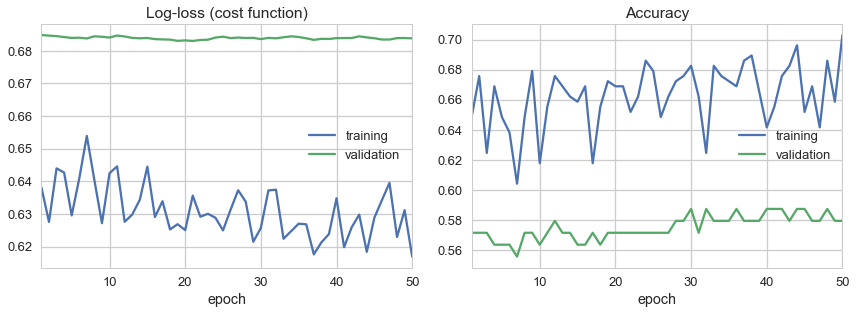

In [43]:
history = xcept_model_surv.fit(x_train, y_train, batch_size=8, epochs=50,
                                      validation_data=(x_test, y_test),callbacks=[learning_rate,PlotLossesKeras()])

In [45]:
#Calculate metrics
test_scores = xcept_model_surv.evaluate(x_test,y_test)

print ("Loss = " + str(test_scores[0]))
print ("Test Accuracy = " + str(test_scores[1]))

126/126 [==============================] - 3s 25ms/step
Loss = 0.6838045820357308
Test Accuracy = 0.5793650774728685


-----------------------------
CNN Roc_auc score :  0.5443137254901961
-----------------------------


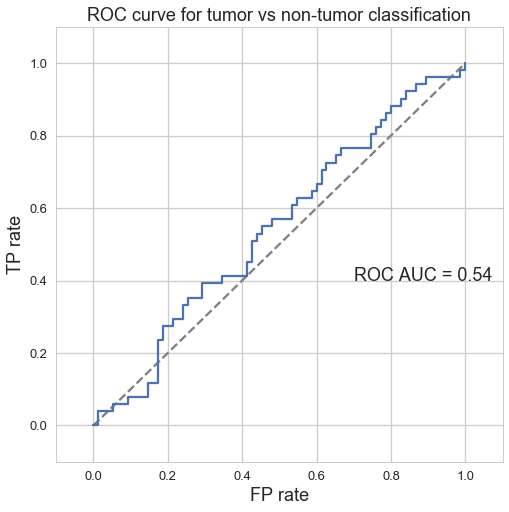

In [46]:
#Plotting ROC curve
predictions = xcept_model_surv.predict(x_test)
plot_results(y_test,predictions,'ROC curve for tumor vs non-tumor classification')

In [ ]:
#Not enough data, hard to find the signal

# Classification of patients gender

In [63]:
#Lets create a dictionary with labels for patients gender
labels={}
for pat_n in range(len(clinical_rec['M/F'])):
    labels[clinical_rec['Subject'][pat_n]] = clinical_rec['M/F'][pat_n] == 'M'
    
#Lets print first 10
for i in list(labels.keys())[0:10]:
    print(i,':',labels[i])

LUNG1-001 : True
LUNG1-002 : True
LUNG1-003 : True
LUNG1-004 : True
LUNG1-005 : True
LUNG1-006 : True
LUNG1-007 : True
LUNG1-008 : True
LUNG1-009 : True
LUNG1-010 : False


In [64]:
#For this task we will use only images with tumor
patients = next(os.walk(jpeg_dir))[2]
images =[]
img_labels =[]
for patient in patients:
    try:
        images.append(imageio.imread(os.path.join(jpeg_dir,patient)))
        img_labels.append(labels[patient[:-4]])
    except:
        print('Something wrong with patient: ',patient[:-4])

images_array = np.array(images)
labels_array = np.array(img_labels,np.uint8).reshape(-1,1)
print('Images array shape: ',images_array.shape,'Labels array shape: ',labels_array.shape)

Images array shape:  (419, 512, 512, 3) Labels array shape:  (419, 1)


In [49]:
#Normalize data before training
mean = np.mean(list(map(lambda x: np.mean(x),images_array)))
std = np.mean(list(map(lambda x: np.std(x),images_array)))
print(mean,std)
normalized_images = np.array(list(map(lambda x: (x-mean)/std,images_array)))
print(normalized_images.shape)

53.97225491774869 86.9674841524258
(419, 512, 512, 3)


Text(0,0.5,'# patients')

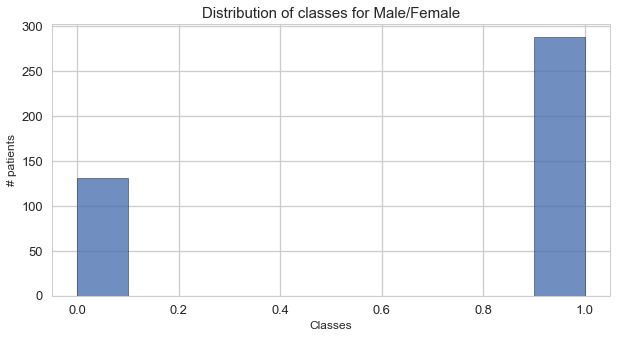

In [50]:
#Check the classes disribution 
plt.figure(figsize=(10,5))
fff = plt.hist(labels_array,bins=10,edgecolor='black', linewidth=0.5,alpha=0.8)
plt.title('Distribution of classes for Male/Female',fontsize=15)
plt.xlabel('Classes',fontsize=12)
plt.ylabel('# patients',fontsize=12)

In [51]:
#Split data
x_train,x_test,y_train,y_test = model_selection.train_test_split(normalized_images,labels_array,test_size=0.3,random_state=1,stratify =labels_array)
print('X_train shape:',x_train.shape,'Y_train shape',y_train.shape)
print('X_test shape:',x_test.shape,'Y_test shape',y_test.shape)

X_train shape: (293, 512, 512, 3) Y_train shape (293, 1)
X_test shape: (126, 512, 512, 3) Y_test shape (126, 1)


In [52]:
xcept_model_gend = Create_a_model(x_train.shape[1:4])
xcept_model_gend.compile(optimizer=keras.optimizers.Adam(lr = 1e-6),loss='binary_crossentropy',metrics=['accuracy'])

(?, 2048)
(?, 1024)
(?, 1)


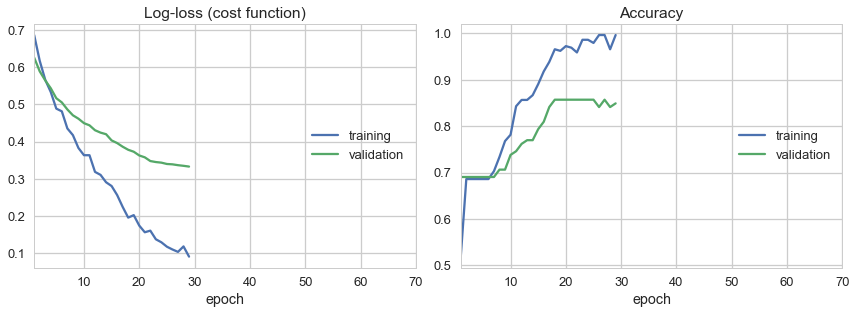

Epoch 30/70
Learning rate is: 1.8990552683500125e-06
288/293 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9931

KeyboardInterrupt: 

In [54]:
history = xcept_model_gend.fit(x_train, y_train, batch_size=8, epochs=70,
                                      validation_data=(x_test, y_test),callbacks=[learning_rate,PlotLossesKeras()])

In [55]:
#Calculate metrics
test_scores = xcept_model_gend.evaluate(x_test,y_test)

print ("Loss = " + str(test_scores[0]))
print ("Test Accuracy = " + str(test_scores[1]))

126/126 [==============================] - 3s 26ms/step
Loss = 0.3298483580823929
Test Accuracy = 0.8571428524123298


-----------------------------
CNN Roc_auc score :  0.8087238432066018
-----------------------------


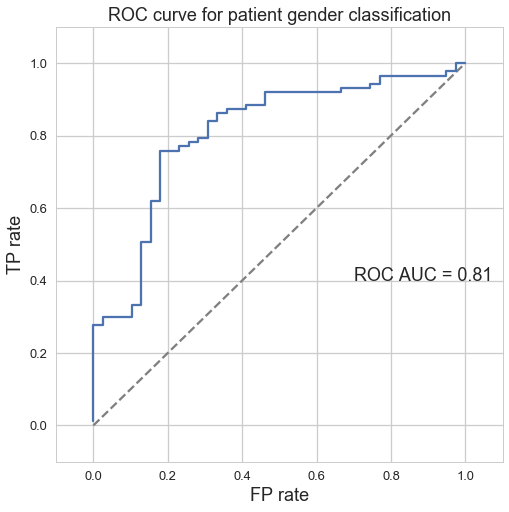

In [56]:
#Plotting ROC curve
predictions = xcept_model.predict(x_test)
plot_results(y_test,predictions,'ROC curve for patient gender classification')